cuda


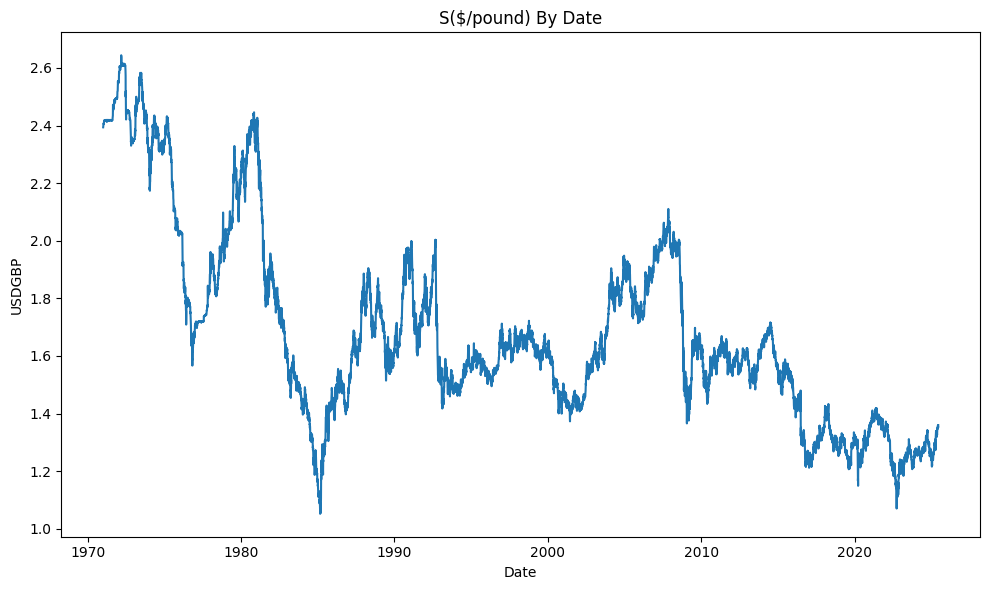

In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv(".env")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler



device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


fred = fr.Fred(fred_api_key)

"""The USD/GBP Spot rate"""

usdgbp = fred.get_series("DEXUSUK")
usdgbp.name = "USDGBP"

df = pd.concat([usdgbp],axis=1).dropna()
df = df.reset_index()
df['Date'] = df['index']
df.drop('index',axis=1,inplace=True)

plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='USDGBP',data=df)
plt.title("S($/pound) By Date")
plt.savefig("images/spotrate.png")
plt.tight_layout()
plt.show()






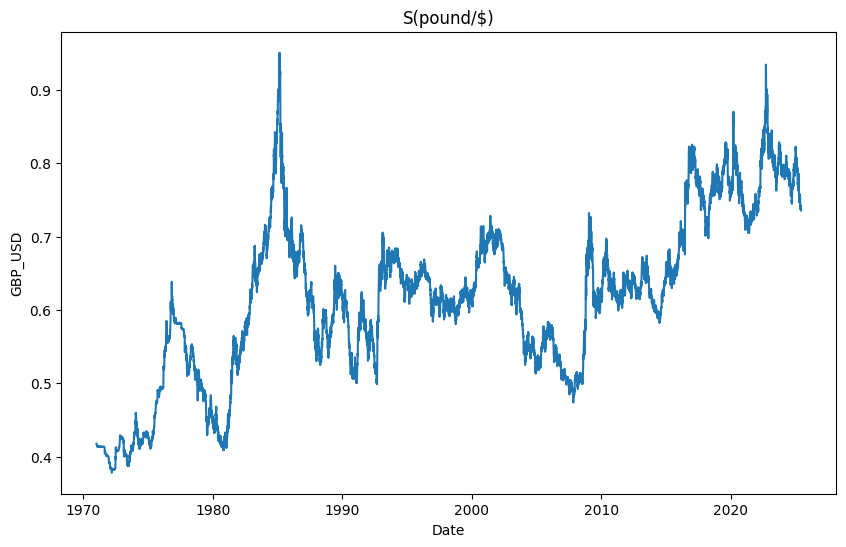

In [2]:
""" Example of S(pound/USD)"""

df1 = df.copy()
df1['GBP_USD'] = 1 / df['USDGBP']

plt.figure(figsize=(10,6))
sns.lineplot(x=df1['Date'],y=df1['GBP_USD'])
plt.title("S(pound/$)")
plt.savefig("images/sportrate_GBPUSD")
plt.show()




In [3]:

""" there is no Arbitrage in the FX market
 1 / USDGBP == GBPUSD; 1 / GBPUSD == USDGBP"""

GBP_USD = 1  / df['USDGBP']

USD_GBP = 1 / GBP_USD

A = np.array([[USD_GBP,GBP_USD],[GBP_USD,USD_GBP]])

print(f'1:1 Parity of of Exchange Rates: {A.T}')



1:1 Parity of of Exchange Rates: [[[2.3938     0.41774584]
  [0.41774584 2.3938    ]]

 [[2.3949     0.41755397]
  [0.41755397 2.3949    ]]

 [[2.3967     0.41724037]
  [0.41724037 2.3967    ]]

 ...

 [[1.3556     0.73768073]
  [0.73768073 1.3556    ]]

 [[1.3589     0.73588932]
  [0.73588932 1.3589    ]]

 [[1.3594     0.73561866]
  [0.73561866 1.3594    ]]]


In [4]:
df1 = df.copy()

df1.shift(1)
df1.dropna(inplace=True)

df_train = df1.iloc[:,0:1].values



train_size = int(len(df_train) * .90)


train_data = df_train[:train_size]
test_data = df_train[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)



def slider(dataframe,seq_length):
    X,y = [],[]
    for i in range(len(dataframe) - seq_length - 1):
        Xi = dataframe[i:(i+seq_length)]
        yi = dataframe[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 7

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()




class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super(LSTM,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        
        self.fc = nn.Linear(hidden_size,output_size)
        
    def forward(self,X):
        h0 = torch.zeros(1,X.size(0),self.hidden_size)
        c0 = torch.zeros(1,X.size(0),self.hidden_size)
        out,_ = self.lstm(X,(h0,c0))
        out = self.fc(out[:,-1,:])
        return out



model = LSTM(input_size=1,hidden_size=512,num_layers=1,output_size=1)
model

LSTM(
  (lstm): LSTM(1, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

In [5]:
model = LSTM(input_size=1,hidden_size=512,num_layers=1,output_size=1)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.MSELoss()
epochs = 200


for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rsme = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RSEM: {train_rsme:.4}; Test RSME: {test_rsme:.4}')

C:\Users\katsa\AppData\Local\Temp\ipykernel_10476\2313886488.py:18: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rsme = np.sqrt(loss_fn(y_pred,y_train))
C:\Users\katsa\AppData\Local\Temp\ipykernel_10476\2313886488.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rsme = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RSEM: 0.4101; Test RSME: 0.09584
Epoch: 1; train_RSEM: 0.3417; Test RSME: 0.04194
Epoch: 2; train_RSEM: 0.2649; Test RSME: 0.07955
Epoch: 3; train_RSEM: 0.1881; Test RSME: 0.1895
Epoch: 4; train_RSEM: 0.2034; Test RSME: 0.3481
Epoch: 5; train_RSEM: 0.2475; Test RSME: 0.4086
Epoch: 6; train_RSEM: 0.2068; Test RSME: 0.353
Epoch: 7; train_RSEM: 0.17; Test RSME: 0.2723
Epoch: 8; train_RSEM: 0.1711; Test RSME: 0.2053
Epoch: 9; train_RSEM: 0.1871; Test RSME: 0.1614
Epoch: 10; train_RSEM: 0.1981; Test RSME: 0.1383
Epoch: 11; train_RSEM: 0.1992; Test RSME: 0.1316
Epoch: 12; train_RSEM: 0.1909; Test RSME: 0.138
Epoch: 13; train_RSEM: 0.1756; Test RSME: 0.1557
Epoch: 14; train_RSEM: 0.158; Test RSME: 0.1833
Epoch: 15; train_RSEM: 0.147; Test RSME: 0.2186
Epoch: 16; train_RSEM: 0.1509; Test RSME: 0.2549
Epoch: 17; train_RSEM: 0.1623; Test RSME: 0.2793
Epoch: 18; train_RSEM: 0.1625; Test RSME: 0.2791
Epoch: 19; train_RSEM: 0.1481; Test RSME: 0.2555
Epoch: 20; train_RSEM: 0.1327; Te

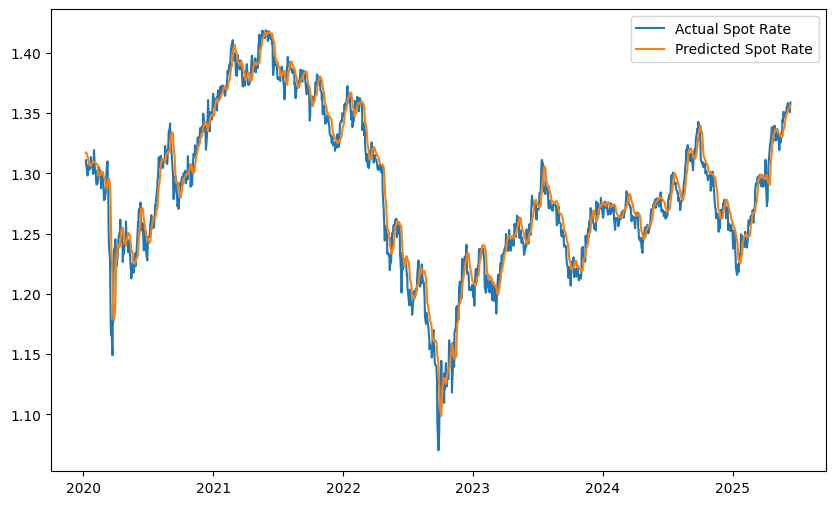

In [6]:

with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)



test_dates = df.iloc[train_size + seq_length:-1]['Date']


comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})



plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Spot Rate"],label="Actual Spot Rate")
plt.plot(comparison_df['Date'],comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate.png")
plt.show()


In [7]:
print(np.round(comparison_df,4).head(20))
print(np.round(comparison_df,4).tail(20))


            Date  Actual Spot Rate  Predicted Spot Rate
12296 2020-01-08            1.3110               1.3171
12297 2020-01-09            1.3069               1.3176
12298 2020-01-10            1.3060               1.3169
12299 2020-01-13            1.2983               1.3139
12300 2020-01-14            1.3018               1.3124
12301 2020-01-15            1.3030               1.3112
12302 2020-01-16            1.3076               1.3089
12303 2020-01-17            1.3029               1.3075
12304 2020-01-21            1.3047               1.3064
12305 2020-01-22            1.3136               1.3060
12306 2020-01-23            1.3104               1.3064
12307 2020-01-24            1.3071               1.3083
12308 2020-01-27            1.3054               1.3094
12309 2020-01-28            1.2996               1.3102
12310 2020-01-29            1.3012               1.3096
12311 2020-01-30            1.3106               1.3094
12312 2020-01-31            1.3195              